## Fit between theory and simulations

Maggie Steiner Feb 2024

### Setup

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from scipy.special import erfinv
from scipy.special import loggamma
from scipy.stats import gamma
from scipy.stats import nbinom
from scipy import special
from scipy.interpolate import interp1d
import sys
import math
import seaborn as sns
import inspect
from scipy import stats
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


from matplotlib.colors import LogNorm
# import statsmodels
# import statsmodels.api as sm
from matplotlib.image import NonUniformImage
import re

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### plotting params ###
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = [8.0,6.0]

### load data from theory run
# data = pd.read_csv("../theory/old_files/results/spatial_integrals_dim2.csv")
# data_pr = pd.read_csv("../theory/old_files/results/cleaned_data_dim2_errorFalse.csv")
# data_pr = data_pr.loc[data_pr['poly_type'] == '1_1']
# w_vals = data['w'].tolist()
# res_vals = data_pr['residues']
# pole_vals = data_pr['poles']

In [5]:
### functions for theory ###
def poles(w,w_vals,pole_vals):
    f=interp1d(w_vals,pole_vals,fill_value="extrapolate")
    return(f(w))

def residues(w,w_vals, res_vals):
    res_vals=[-1*x for x in res_vals]
    f = interp1d(w_vals,res_vals,fill_value="extrapolate")
    return (f(w))

def get_gammae(w,s,w_vals,pole_vals,N=10000,sigma=1,d=1):
    l_c=np.sqrt(sigma/s)
    return(s*N*(l_c**d)*poles(w/l_c,w_vals,pole_vals))

def get_thetae(w,s,w_vals,res_vals,mu=1e-8,N=10000,sigma=1,d=1):
    l_c = np.sqrt(sigma / s)
    return(mu*N*(l_c**d)*residues(w/l_c,w_vals,res_vals))

def finite_sfs_k(n,k,w,s,w_vals,pole_vals,res_vals,mu=1e-7,N=100,sigma=1,d=2):
    gammae = get_gammae(w,s,w_vals,pole_vals,N,sigma,d)
    thetae = get_thetae(w,s,w_vals,res_vals,mu,N,sigma,d)
    logval = k*np.log(n)+thetae*np.log(gammae)-(k+thetae)*np.log(n+gammae)+loggamma(k+thetae)-loggamma(k+1)-loggamma(thetae)
    return(np.e**logval)

In [3]:
color_palette_original = [
    "#003f5c",
    "#2f4b7c",
    "#665191",
    "#a05195",
    "#d45087",
    "#f95d6a",
    "#ff7c43",
    "#ffa600"
]

### Matched parameters

In [44]:
### load SLiM data ###
slim_data = pd.read_csv("../simulations/results_Dec2023/summary_df_norecap_dec2023.tsv", sep="\t")
slim_data = slim_data[slim_data['f_per_kb'] != 0]

slim_data_s_01 = slim_data[slim_data['s'] == -0.1]
slim_data_s_001 = slim_data[slim_data['s'] == -0.01]
slim_data_s_0001 = slim_data[slim_data['s'] == -0.001]

w_vals_slim = slim_data_s_01['width'].unique()
w_vals_slim = np.sort(w_vals_slim)
vals_to_plot = [w_vals_slim[1],w_vals_slim[-4]] # choice of w vals

### parameters for theory
mu=(1e-10)#*5.6 # mutation rate from simulations times 5.6 (cycle adjustment)
nval = 25 # sample size
dens = 5#/(4.08**2) # density with unit adjustment
sigmaval = 0.2#*4.08 # parent offspring dispersal with unit adjustment
s_list = [0.1/2,0.01/2,0.001/2] # list of selection coefficients
# s_list_adj = [x for x in s_list] #*5.6 old code to change to cycle timing
w_vals_plot2 = [x for x in vals_to_plot] # w vals in theory units
kmax=1000 # plotting param
step=1 # plotting param

colors = [color_palette_original[1],color_palette_original[6]]

In [17]:
slim_data['n']

1       25
4       25
6       25
7       25
8       25
        ..
6137    28
6138    28
6139    28
6140    28
6141    28
Name: n, Length: 3189, dtype: int64

In [46]:
### w values to be plotted (SLIM) ###
print(vals_to_plot)

[1.224744871391589, 45.31556024148879]


In [9]:
5/(4.08**2)

0.30036524413687044

In [37]:
### w values to be plotted (theory) ###
w_vals_plot2

[1.224744871391589, 45.31556024148879]

In [38]:
### CORRECT THEORY CODE 

from scipy.special import exp1,factorial

def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

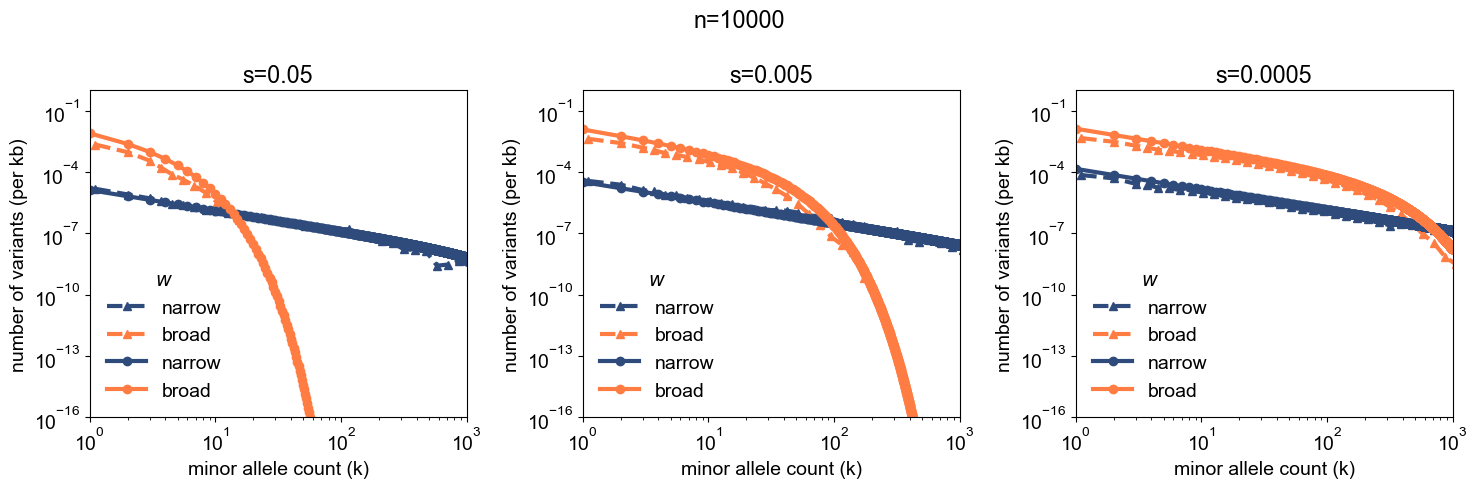

In [47]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

nval=10000

### PLOT SLIM SFS's ###

for width in vals_to_plot:
    sfs_data = slim_data_s_01
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[0].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-16, 1e0)
    axs[0].set_xlim(1e0,1e3)
    axs[0].set_xlabel("minor allele count (k)")
    axs[0].set_ylabel("number of variants (per kb)")
    
    sfs_data = slim_data_s_001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[1].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylim(1e-16, 1e0)
    axs[1].set_xlim(1e0,1e3)
    axs[1].set_xlabel("minor allele count (k)")
    axs[1].set_ylabel("number of variants (per kb)")

    sfs_data = slim_data_s_0001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[2].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylim(1e-16, 1e0)
    axs[2].set_xlim(1e0,1e3)
    axs[2].set_xlabel("minor allele count (k)")
    axs[2].set_ylabel("number of variants (per kb)")
    
### PLOT THEORY SFS's ###    

scale = 1000

sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[0],rho=dens,sigma=sigmaval,w=w_vals_plot2[0])*scale for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[0],rho=dens,sigma=sigmaval,w=w_vals_plot2[1])*scale for x in range(0,kmax,step)]

# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[0].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[0].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-16, 1e0)
axs[0].set_xlim(1e0,1e3)
axs[0].set_xlabel("minor allele count (k)")
axs[0].set_ylabel("number of variants (per kb)")

sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[1],rho=dens,sigma=sigmaval,w=w_vals_plot2[0])*scale for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[1],rho=dens,sigma=sigmaval,w=w_vals_plot2[1])*scale for x in range(0,kmax,step)]
# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[1].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[1].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-16, 1e0)
axs[1].set_xlim(1e0,1e3)
axs[1].set_xlabel("minor allele count (k)")
axs[1].set_ylabel("number of variants (per kb)")


sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[2],rho=dens,sigma=sigmaval,w=w_vals_plot2[0])*scale for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[2],rho=dens,sigma=sigmaval,w=w_vals_plot2[1])*scale for x in range(0,kmax,step)]
# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[2].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[2].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_ylim(1e-16, 1e0)
axs[2].set_xlim(1e0,1e3)
axs[2].set_xlabel("minor allele count (k)")
axs[2].set_ylabel("number of variants (per kb)")

axs[0].set_title("s="+str(s_list[0]))
axs[1].set_title("s="+str(s_list[1]))
axs[2].set_title("s="+str(s_list[2]))


axs[0].legend(title=r"$w$", frameon=False)
axs[1].legend(title=r"$w$", frameon=False)
axs[2].legend(title=r"$w$", frameon=False)

plt.suptitle(f'n={nval}')
plt.tight_layout()
plt.show()
# plt.savefig("sims_theory_incorrectmu.pdf")

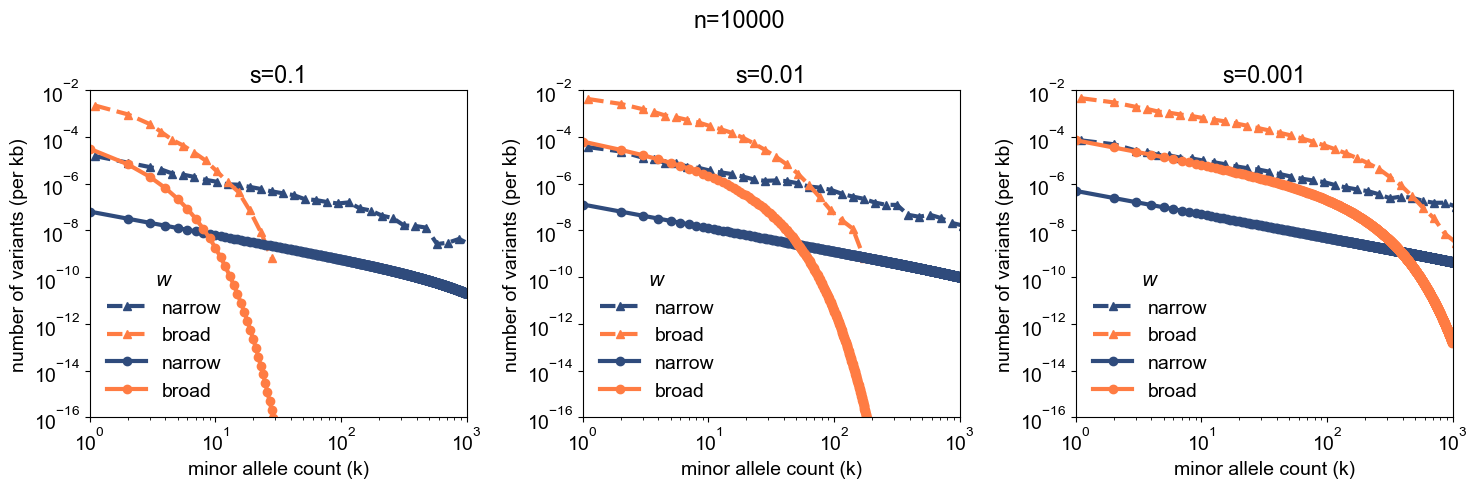

In [39]:
nval = 10000

fig, axs = plt.subplots(1,3,figsize=(15,5))

### PLOT SLIM SFS's ###

for width in vals_to_plot:
    sfs_data = slim_data_s_01
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[0].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-8, 1e-2)
    axs[0].set_xlim(1e0,1e3)
    axs[0].set_xlabel("minor allele count (k)")
    axs[0].set_ylabel("number of variants (per kb)")
    
    sfs_data = slim_data_s_001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[1].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylim(1e-8, 1e-2)
    axs[1].set_xlim(1e0,1e3)
    axs[1].set_xlabel("minor allele count (k)")
    axs[1].set_ylabel("number of variants (per kb)")

    sfs_data = slim_data_s_0001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[2].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylim(1e-8, 1e-2)
    axs[2].set_xlim(1e0,1e3)
    axs[2].set_xlabel("minor allele count (k)")
    axs[2].set_ylabel("number of variants (per kb)")
    
### PLOT THEORY SFS's ###    

sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[0],rho=dens,sigma=sigmaval,w=w_vals_plot2[0]) for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[0],rho=dens,sigma=sigmaval,w=w_vals_plot2[1]) for x in range(0,kmax,step)]

# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[0].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[0].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-16, 1e-2)
axs[0].set_xlim(1e0,1e3)
axs[0].set_xlabel("minor allele count (k)")
axs[0].set_ylabel("number of variants (per kb)")

sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[1],rho=dens,sigma=sigmaval,w=w_vals_plot2[0]) for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[1],rho=dens,sigma=sigmaval,w=w_vals_plot2[1]) for x in range(0,kmax,step)]
# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[1].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[1].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-16, 1e-2)
axs[1].set_xlim(1e0,1e3)
axs[1].set_xlabel("minor allele count (k)")
axs[1].set_ylabel("number of variants (per kb)")


sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[2],rho=dens,sigma=sigmaval,w=w_vals_plot2[0]) for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[2],rho=dens,sigma=sigmaval,w=w_vals_plot2[1]) for x in range(0,kmax,step)]
# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[2].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[2].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_ylim(1e-16, 1e-2)
axs[2].set_xlim(1e0,1e3)
axs[2].set_xlabel("minor allele count (k)")
axs[2].set_ylabel("number of variants (per kb)")

axs[0].set_title("s="+str(s_list[0]))
axs[1].set_title("s="+str(s_list[1]))
axs[2].set_title("s="+str(s_list[2]))


axs[0].legend(title=r"$w$", frameon=False)
axs[1].legend(title=r"$w$", frameon=False)
axs[2].legend(title=r"$w$", frameon=False)


plt.suptitle(f'n={nval}')
plt.tight_layout()
plt.show()
# plt.savefig("sims_theory_incorrectmu.pdf")

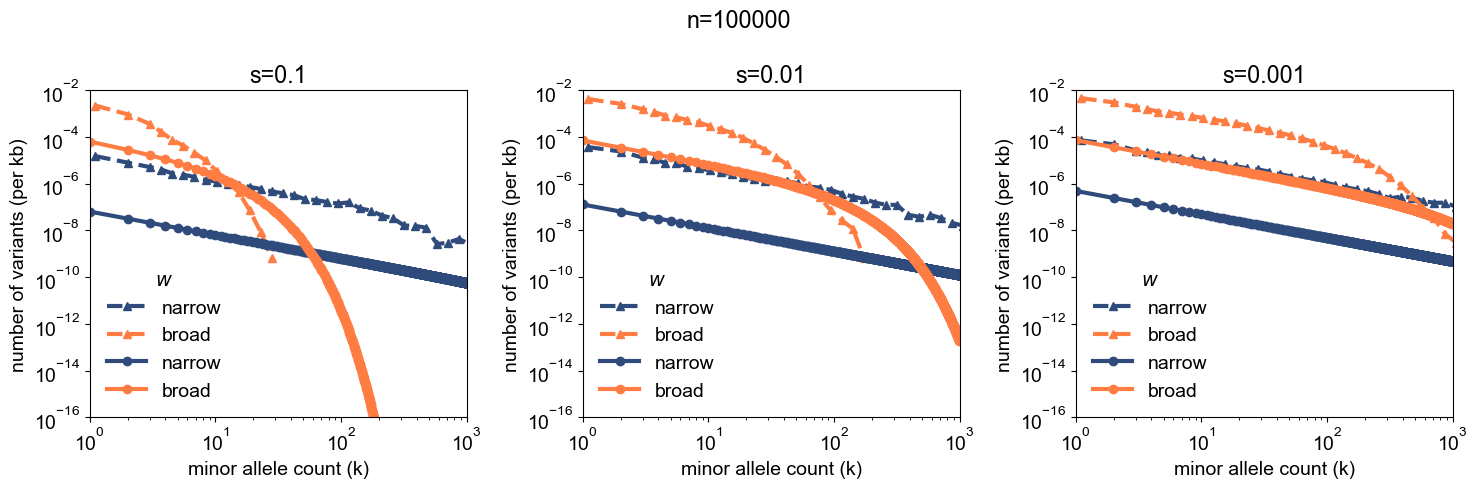

In [40]:
nval = 100000

fig, axs = plt.subplots(1,3,figsize=(15,5))

### PLOT SLIM SFS's ###

for width in vals_to_plot:
    sfs_data = slim_data_s_01
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[0].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-8, 1e-2)
    axs[0].set_xlim(1e0,1e3)
    axs[0].set_xlabel("minor allele count (k)")
    axs[0].set_ylabel("number of variants (per kb)")
    
    sfs_data = slim_data_s_001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[1].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylim(1e-8, 1e-2)
    axs[1].set_xlim(1e0,1e3)
    axs[1].set_xlabel("minor allele count (k)")
    axs[1].set_ylabel("number of variants (per kb)")

    sfs_data = slim_data_s_0001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow" if width == vals_to_plot[0] else "broad"
    axs[2].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylim(1e-8, 1e-2)
    axs[2].set_xlim(1e0,1e3)
    axs[2].set_xlabel("minor allele count (k)")
    axs[2].set_ylabel("number of variants (per kb)")
    
### PLOT THEORY SFS's ###    

sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[0],rho=dens,sigma=sigmaval,w=w_vals_plot2[0]) for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[0],rho=dens,sigma=sigmaval,w=w_vals_plot2[1]) for x in range(0,kmax,step)]

# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[0].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[0].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-16, 1e-2)
axs[0].set_xlim(1e0,1e3)
axs[0].set_xlabel("minor allele count (k)")
axs[0].set_ylabel("number of variants (per kb)")

sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[1],rho=dens,sigma=sigmaval,w=w_vals_plot2[0]) for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[1],rho=dens,sigma=sigmaval,w=w_vals_plot2[1]) for x in range(0,kmax,step)]
# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[1].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[1].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-16, 1e-2)
axs[1].set_xlim(1e0,1e3)
axs[1].set_xlabel("minor allele count (k)")
axs[1].set_ylabel("number of variants (per kb)")


sfs_w0 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[2],rho=dens,sigma=sigmaval,w=w_vals_plot2[0]) for x in range(0,kmax,step)]
sfs_w1 = [get_sfs_theory(x,n=nval,mu=mu,s=s_list[2],rho=dens,sigma=sigmaval,w=w_vals_plot2[1]) for x in range(0,kmax,step)]
# sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
# sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

axs[2].plot(range(0, kmax, step), sfs_w0, label="narrow", marker='o', color=colors[0])
axs[2].plot(range(0, kmax, step), sfs_w1, label="broad", marker='o', color=colors[1])
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_ylim(1e-16, 1e-2)
axs[2].set_xlim(1e0,1e3)
axs[2].set_xlabel("minor allele count (k)")
axs[2].set_ylabel("number of variants (per kb)")

axs[0].set_title("s="+str(s_list[0]))
axs[1].set_title("s="+str(s_list[1]))
axs[2].set_title("s="+str(s_list[2]))


axs[0].legend(title=r"$w$", frameon=False)
axs[1].legend(title=r"$w$", frameon=False)
axs[2].legend(title=r"$w$", frameon=False)


plt.suptitle(f'n={nval}')
plt.tight_layout()
plt.show()
# plt.savefig("sims_theory_incorrectmu.pdf")

### Adjust to match singletons

<ipython-input-17-2da4adf04ce4>:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[0].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
<ipython-input-17-2da4adf04ce4>:26: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[1].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
<ipython-input-17-2da4adf04ce4>:39: FutureWarning: The behavior 

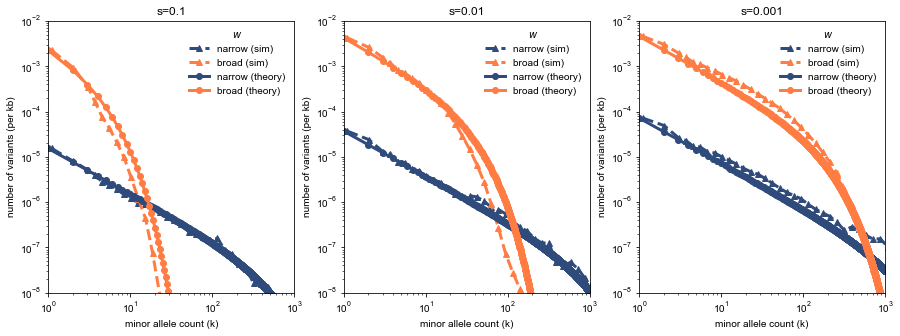

In [17]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

singletons_s_01 = []
singletons_s_001 = []
singletons_s_0001 = []

for width in vals_to_plot:
    sfs_data = slim_data_s_01
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow (sim)" if width == vals_to_plot[0] else "broad (sim)"
    singletons_s_01.append(sfs_temp['f_per_kb'].tolist()[0])
    axs[0].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[0].set_xscale("log")
    axs[0].set_yscale("log")
    axs[0].set_ylim(1e-8, 1e-2)
    axs[0].set_xlim(1e0,1e3)
    axs[0].set_xlabel("minor allele count (k)")
    axs[0].set_ylabel("number of variants (per kb)")
    
    sfs_data = slim_data_s_001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow (sim)" if width == vals_to_plot[0] else "broad (sim)"
    singletons_s_001.append(sfs_temp['f_per_kb'].tolist()[0])
    axs[1].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_ylim(1e-8, 1e-2)
    axs[1].set_xlim(1e0,1e3)
    axs[1].set_xlabel("minor allele count (k)")
    axs[1].set_ylabel("number of variants (per kb)")

    sfs_data = slim_data_s_0001
    sfs_temp = sfs_data[sfs_data['width'] == width]
    col_temp = colors[0] if width == vals_to_plot[0] else colors[1]
    lab_temp = "narrow (sim)" if width == vals_to_plot[0] else "broad (sim)"
    singletons_s_0001.append(sfs_temp['f_per_kb'].tolist()[0])
    axs[2].plot(sfs_temp['allele counts'][0:], sfs_temp['f_per_kb'], color=col_temp, label=lab_temp, marker='^',linestyle='dashed')
    axs[2].set_xscale("log")
    axs[2].set_yscale("log")
    axs[2].set_ylim(1e-8, 1e-2)
    axs[2].set_xlim(1e0,1e3)
    axs[2].set_xlabel("minor allele count (k)")
    axs[2].set_ylabel("number of variants (per kb)")
    
sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[0], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

ratio_w0 = sfs_w0[1]/singletons_s_01[0]
sfs_w0_adj = [x/ratio_w0 for x in sfs_w0]

ratio_w1 = sfs_w1[1]/singletons_s_01[1]
sfs_w1_adj = [x/ratio_w1 for x in sfs_w1]

axs[0].plot(range(0, kmax, step), sfs_w0_adj, label="narrow (theory)", marker='o', color=colors[0])
axs[0].plot(range(0, kmax, step), sfs_w1_adj, label="broad (theory)", marker='o', color=colors[1])
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-8, 1e-2)
axs[0].set_xlim(1e0,1e3)
axs[0].legend(title=r"$w$", frameon=False)
axs[0].set_xlabel("minor allele count (k)")
axs[0].set_ylabel("number of variants (per kb)")


sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[1], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

ratio_w0 = sfs_w0[1]/singletons_s_001[0]
sfs_w0_adj = [x/ratio_w0 for x in sfs_w0]

ratio_w1 = sfs_w1[1]/singletons_s_001[1]
sfs_w1_adj = [x/ratio_w1 for x in sfs_w1]

axs[1].plot(range(0, kmax, step), sfs_w0_adj, label="narrow (theory)", marker='o', color=colors[0])
axs[1].plot(range(0, kmax, step), sfs_w1_adj, label="broad (theory)", marker='o', color=colors[1])
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-8, 1e-2)
axs[1].set_xlim(1e0,1e3)
axs[1].legend(title=r"$w$", frameon=False)
axs[1].set_xlabel("minor allele count (k)")
axs[1].set_ylabel("number of variants (per kb)")


sfs_w0 = [finite_sfs_k(nval, k, w_vals_plot2[0], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]
sfs_w1 = [finite_sfs_k(nval, k, w_vals_plot2[1], s_list[2], w_vals, pole_vals, res_vals, sigma=sigmaval, N=dens, mu=mu)*1e3 for k in range(0, kmax, step)]

ratio_w0 = sfs_w0[1]/singletons_s_0001[0]
sfs_w0_adj = [x/ratio_w0 for x in sfs_w0]

ratio_w1 = sfs_w1[1]/singletons_s_0001[1]
sfs_w1_adj = [x/ratio_w1 for x in sfs_w1]

axs[2].plot(range(0, kmax, step), sfs_w0_adj, label="narrow (theory)", marker='o', color=colors[0])
axs[2].plot(range(0, kmax, step), sfs_w1_adj, label="broad (theory)", marker='o', color=colors[1])
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_ylim(1e-8, 1e-2)
axs[2].set_xlim(1e0,1e3)
axs[2].legend(title=r"$w$", frameon=False)
axs[2].set_xlabel("minor allele count (k)")
axs[2].set_ylabel("number of variants (per kb)")

axs[0].set_title("s="+str(s_list[0]))
axs[1].set_title("s="+str(s_list[1]))
axs[2].set_title("s="+str(s_list[2]))

# plt.savefig("theory_sim_matchsingletons.pdf")
plt.show()

In [161]:
print(ratio_w0)

1.3066067239591745
